In [1]:
%load_ext autoreload
%autoreload 2

# Library imports

In [2]:
import os
import numpy as np
from skimage import io
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from time import sleep
from time import time
from utils.dirs import listdir_nohidden
from utils.factory import create
from utils.logger import Logger
from utils.dirs import create_dirs
from models import *
from trainers import *
import tensorflow as tf
init = tf.global_variables_initializer()
from utils.config import process_config
from utils.config import get_config_from_json
from utils.visualization import *
#import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, precision_recall_curve
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import numpy as np
from time import sleep
from time import time
plt.style.use('seaborn') 
inference_dir = "inference_saves"
if not os.path.exists(inference_dir):
    os.mkdir(inference_dir)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
%matplotlib inline

# Sencebgan

In [4]:
config_file = "configs/visualize/sencebgan.json"
config, _ = get_config_from_json(config_file)
config.exp.name = "sencebgan_standard"
senceb_config = process_config(config)

In [5]:
from models.new.sencebgan import SENCEBGAN
from utils.DataLoader import DataLoader
from utils.logger import Logger
from utils.factory import create
from data_loader.data_generator import DataGenerator

l = Logger(senceb_config)
logger = l.get_logger(__name__)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# Create the dataloader
data = create("data_loader." + senceb_config.data_loader.name)(senceb_config)
# Create the model instance
model = create("models.new." + senceb_config.model.name)(senceb_config)

2019-07-07 05:55:44,190 — utils.DataLoader — INFO — Train Dataset is already populated.
2019-07-07 05:55:44,214 — utils.DataLoader — INFO — Test Dataset is already populated
2019-07-07 05:55:44,215 — data_loader.data_generator — INFO — Data is loading...
2019-07-07 05:55:44,627 — utils.DataLoader — INFO — Train Dataset is Loaded
2019-07-07 06:24:28,195 — utils.DataLoader — INFO — Test Dataset is Loaded
2019-07-07 06:24:48,001 — base.base_model — INFO — Building training graph...
2019-07-07 06:24:55,179 — base.base_model — INFO — Building Testing Graph...


In [6]:
model.load(sess)

2019-07-07 06:24:58,005 — base.base_model — INFO — Loading model checkpoint Ablation/sencebgan_standard/checkpoint/-684000 ...

INFO:tensorflow:Restoring parameters from Ablation/sencebgan_standard/checkpoint/-684000
2019-07-07 06:25:04,974 — base.base_model — INFO — Model loaded


100%|██████████| 4965/4965 [6:56:28<00:00,  8.89s/it]


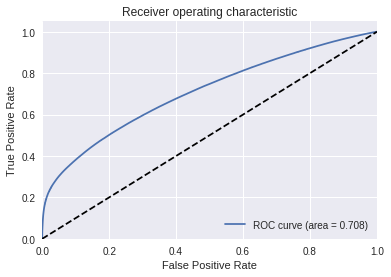

In [7]:
scores_final_2 = []
imgs = []
inference_time = []
true_labels = []
noise_dim = senceb_config.trainer.noise_dim
test_loop = tqdm(range(senceb_config.data_loader.num_iter_per_test))
sess.run(data.test_iterator.initializer)
for _ in test_loop:
    test_batch_begin = time()
    test_batch, test_labels, ground_truth = sess.run(
        [data.test_image, data.test_label, data.ground_truth]
    )
    test_loop.refresh()  # to show immediately the update
    sleep(0.01)
    noise = np.random.normal(
                loc=0.0, scale=1.0, size=[senceb_config.data_loader.test_batch, noise_dim]
    )
    feed_dict = {
        model.image_input: test_batch,
        model.noise_tensor: noise,
        model.is_training_gen: False,
        model.is_training_dis: False,
        model.is_training_enc_g: False,
        model.is_training_enc_r: False,
    }
    scores_final_2 += sess.run(model.final_score_1, feed_dict=feed_dict).tolist()
    inference_time.append(time() - test_batch_begin)
    true_labels += test_labels.tolist()
    imgs.append(np.asarray(test_batch))
true_labels = np.asarray(true_labels)
inference_time = np.mean(inference_time)
scores_final_2 = np.asarray(scores_final_2)
fpr, tpr, _ = roc_curve(true_labels, scores_final_2)
roc_auc = auc(fpr, tpr)  # compute area under the curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.3f)" % (roc_auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")



In [8]:
#patches = connect_imgs(imgs)

In [10]:
patches = np.stack(imgs,axis=0)
patches = patches.reshape((5282760,32,32))

In [ ]:
len(imgs)

In [47]:
predictions = compute_predictions(scores=scores_final_2,percentile=80)

true predictions: 55003
False Positives: 56914
False Negatives: 27250


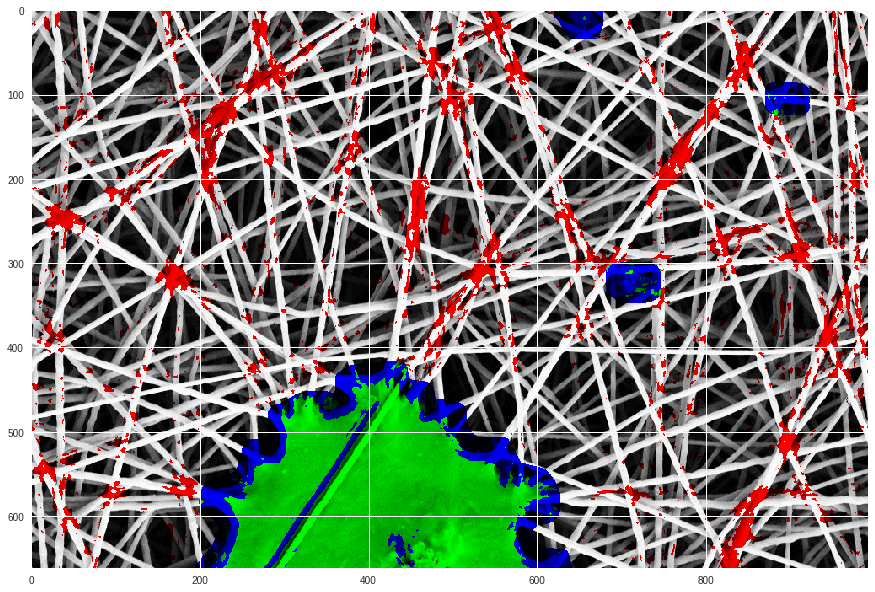

In [35]:
paint_anomalies_pixelwise(0,patches,predictions,true_labels,statistics=True,show=True)

In [ ]:
plt.savefig("test")

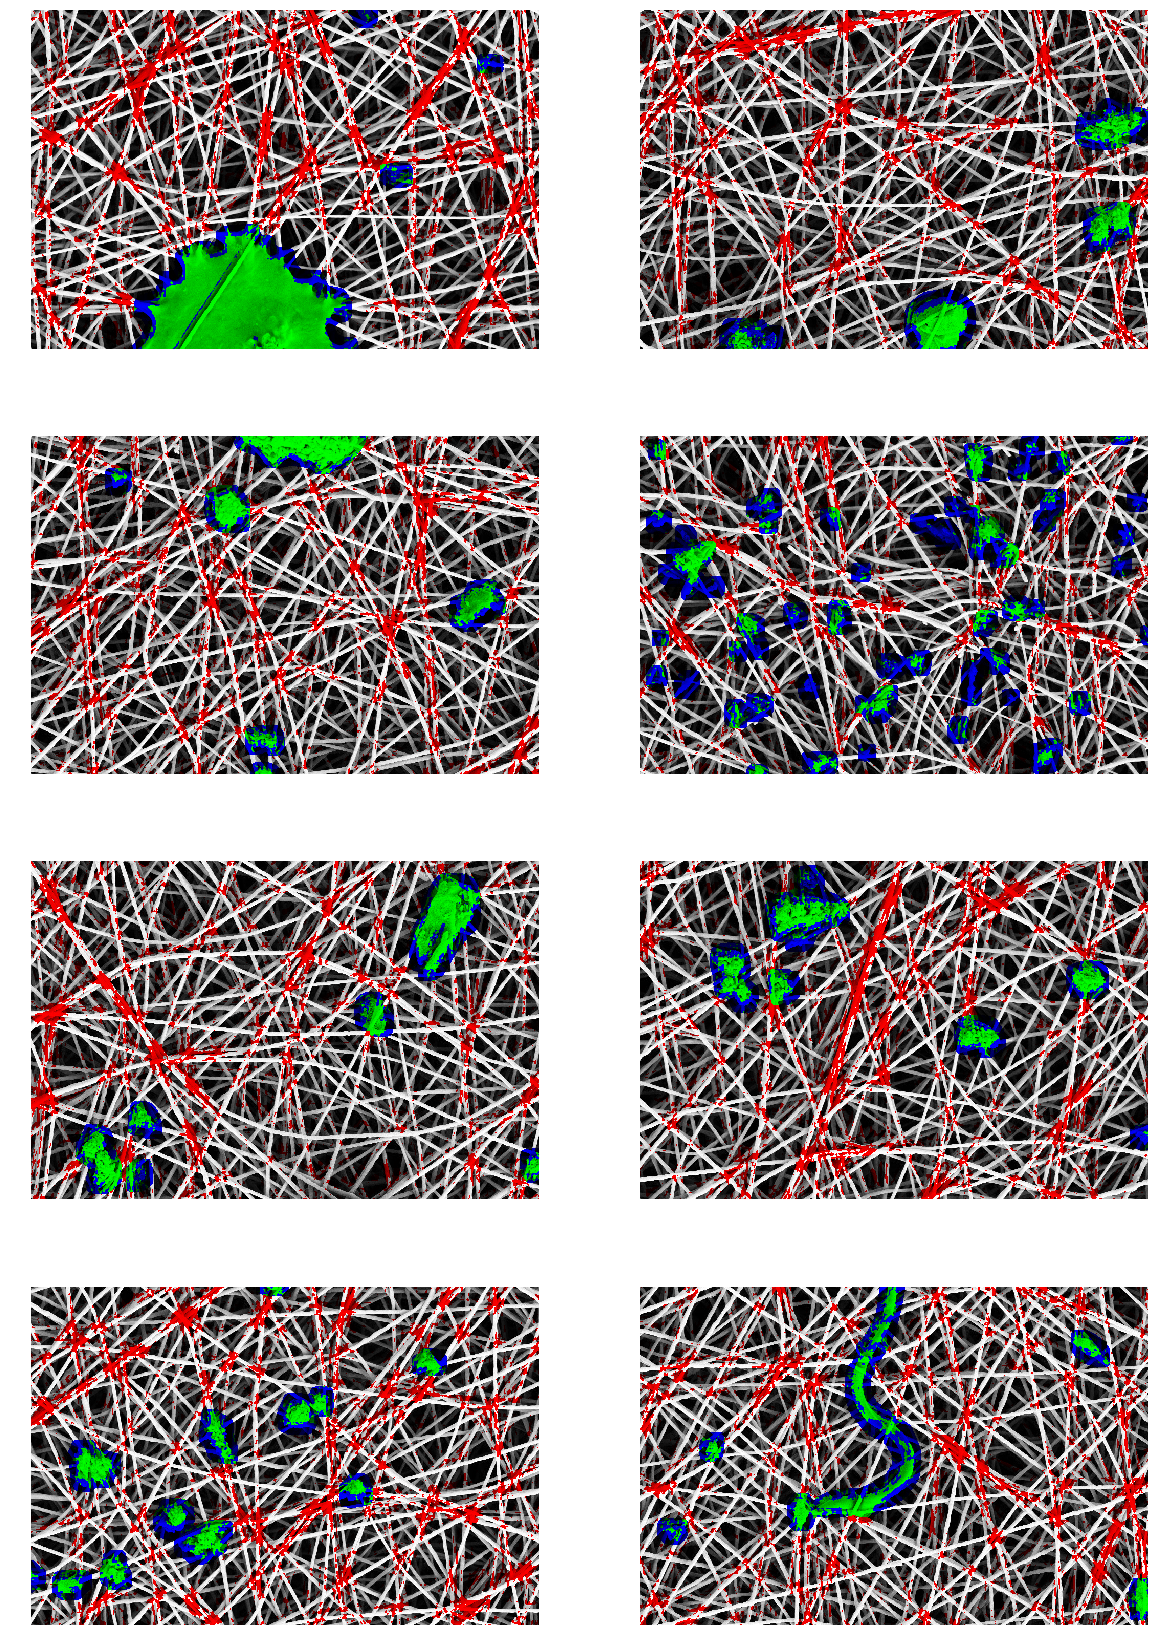

In [48]:
fig = plt.figure(1,figsize=(20,30))
for i in range(8):
    hoho = paint_anomalies_pixelwise(i,patches,predictions,true_labels)
    plt.subplot(4,2, i+1)
    plt.imshow(hoho)
    plt.axis('off')

In [49]:
fig.savefig("test_80.png", bbox_inches='tight')